# 1. Preamble

This is a practice for classification projects. I will analyze datasets from Kaggle.

The initial approach is:

#### a) import the databases:
    
    i) check the parameters required to get the file properly loaded

#### b) table cleansing:
    
    i) adjust columns headers and indexes
    ii) evaluate table completeness (NaN, field types, etc)

#### c) Numerical columns:

    i) quick statistical analysis (descriptive statistics) of the columns (range - minimum and maximum, mean, standard deviation, median, mode, N)
    ii) graphical evaluation (whisker box-plot and histograms)

#### d) Categorical columns:
    
    i) sort uniques to check mispelling or variations of equivalent values
    ii) count of distinct values
    iii) graphical representation of the counts (histograms)

#### e) definition of the target variable for a classification problem:
    i) discover which variable is the classifier, i.e. the output of your model that will tell you to which group each input "belongs to"
    
##### f) Initial exploration
    
    i) scatterplot of each parameter versus the expected classification

*Let's start!!!*

# Classify gestures by reading muscle activity: 
https://www.kaggle.com/kyr7plus/emg-4

## Context
My friends and I are creating an open source prosthetic control system which would enable prosthetic devices to have multiple degrees of freedom. https://github.com/cyber-punk-me

VIDEO

The system is built of several components. It connects a muscle activity (EMG, Electromyography) sensor to a user Android/Android Things App. The app collects data, then a server builds a Tensorflow model specifically for this user. After that the model can be downloaded and executed on the device to control motors or other appendages.

This dataset can be used to map user residual muscle gestures to certain actions of a prosthetic such as open/close hand or rotate wrist.

For a reference please watch a video on this topic : Living with a mind-controlled robot arm

## Content
Four classes of motion were written from MYO armband with the help of our app https://github.com/cyber-punk-me/nukleos.
The MYO armband has 8 sensors placed on skin surface, each measures electrical activity produced by muscles beneath.

Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. The last column is a resulting gesture that was made while recording the data (classes 0-3)
So each line has the following structure:

[8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]
Data was recorded at 200 Hz, which means that each line is 8*(1/200) seconds = 40ms of record time.

A classifier given 64 numbers would predict a gesture class (0-3).
Gesture classes were : rock - 0, scissors - 1, paper - 2, ok - 3. Rock, paper, scissors gestures are like in the game with the same name, and OK sign is index finger touching the thumb and the rest of the fingers spread. Gestures were selected pretty much randomly.

Each gesture was recorded 6 times for 20 seconds. Each time recording started with the gesture being already prepared and held. Recording stopped while the gesture was still being held. In total there is 120 seconds of each gesture being held in fixed position. All of them recorded from the same right forearm in a short timespan. Every recording of a certain gesture class was concatenated into a .csv file with a corresponding name (0-3).

## Inspiration
Be one of the real cyber punks inventing electronic appendages. Let's help people who really need it. There's a lot of work and cool stuff ahead =)

In [1]:
# Default libraries: pandas, numpy
import pandas as pd
import numpy as np

import math

# Load collections of functions
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime

from clustergram import Clustergram
# import urbangrammar_graphics as ugg
import seaborn as sns

from sklearn.preprocessing import scale

In [2]:
# import sys
# print(sys.path)
# help(pd.read_csv)

### A. IMPORT DATA

In [3]:
main_path = 'C:\\Users\\map_f\\OneDrive\\Documents\\Dropbox\\Springboard\\GitHub\\Classification\\'
project_path = 'Muscles_activation\\'
path = main_path + project_path

# parser = TextFileReader(fp_or_buf, **kwds)
R1 = pd.read_csv(path + '0.csv',index_col= None,header=None,delimiter=',')
R2 = pd.read_csv(path + '1.csv',index_col= None,header=None,delimiter=',')
R3 = pd.read_csv(path + '2.csv',index_col= None,header=None,delimiter=',')
R4 = pd.read_csv(path + '3.csv',index_col= None,header=None,delimiter=',')
# type(raw_data)

### B. DATA "CLEANSING"

In [4]:
R1.head(10)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0
5,15.0,-5.0,-5.0,-15.0,12.0,-22.0,-38.0,36.0,9.0,6.0,...,-26.0,5.0,6.0,6.0,11.0,5.0,30.0,-48.0,25.0,0
6,-12.0,-5.0,-1.0,4.0,-16.0,-17.0,-69.0,-16.0,-12.0,-3.0,...,1.0,-36.0,-10.0,-12.0,-16.0,-12.0,-47.0,6.0,-30.0,0
7,43.0,0.0,-2.0,6.0,11.0,26.0,51.0,27.0,-9.0,-2.0,...,41.0,15.0,4.0,10.0,25.0,9.0,13.0,73.0,47.0,0
8,-26.0,-9.0,-18.0,-60.0,-23.0,-35.0,-85.0,-40.0,27.0,10.0,...,-17.0,-7.0,-1.0,2.0,10.0,-6.0,7.0,-2.0,-1.0,0
9,-34.0,3.0,9.0,29.0,6.0,-25.0,-124.0,-1.0,12.0,-6.0,...,-6.0,41.0,0.0,-10.0,-17.0,21.0,3.0,42.0,11.0,0


In [5]:
R1.shape

(2910, 65)

Including a identifier for each table and appending all data set into a single table.

In [20]:
R1['tag'] = 1
R2['tag'] = 2
R3['tag'] = 3
R4['tag'] = 4

raw_data = R1.append(R2.append(R3.append(R4)))

In [24]:
raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,tag
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0,1
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0,1
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0,1
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0,1
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0,1


In [30]:
raw_data = raw_data.dropna(how='all')

In [31]:
df = raw_data

### C. Numerical columns

In [32]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,tag
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094,1.503254,2.503254
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091,1.117541,1.117541
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000,0.000000,1.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000,1.000000,2.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,2.000000,3.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000,3.000000,4.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000,3.000000,4.000000


In [33]:
df.median()

0     -1.0
1     -1.0
2     -1.0
3     -1.0
4      0.0
      ... 
61    -1.0
62    -1.0
63    -1.0
64     2.0
tag    3.0
Length: 66, dtype: float64

In [34]:
df.mode()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,tag
0,-1.0,-1.0,-1.0,-2.0,-1.0,0.0,-1.0,-2.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-2.0,-1.0,-2.0,-1.0,-2.0,2.0,3.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# df.plot(subplots=True, layout=(9,8))

In [48]:
# plt.clf
# plt.boxplot(df)
# plt.show()

### D. Categorical

In [49]:
# Uniques
import pandas as pd

colNames = df.columns.tolist()
uniqueValsList = []                    

for each in colNames:
    uniqueVals = list(df[each].unique())
    uniqueValsList.append(pd.Series(data=uniqueVals,name=each))

maxlen = 0
for each in uniqueValsList:
    if len(each) > maxlen:
        maxlen = len(each)

fillerData = np.empty((maxlen,len(colNames),))
dfDiff = pd.DataFrame(columns=colNames,data=fillerData)

for i in range(len(uniqueValsList)):
    dfDiff[colNames[i]] = uniqueValsList[i]
dfDiff


# from IPython.display import HTML, display
# import tabulate

# listOfLists = []
# for i in range(len(uniqueValsList)):
#     thisList = []
#     thisList.append(colNames[i])
#     for each in uniqueValsList[i].tolist():
#         thisList.append(each)
#     listOfList.append(thisList)

# display(HTML(tabulate.tabulate(listOfLists, tablefmt='html')))

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,tag
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0.0,1.0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,47.0,6.0,6.0,-8.0,13.0,21.0,111.0,15.0,1.0,2.0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,7.0,7.0,1.0,11.0,7.0,39.0,114.0,48.0,2.0,3.0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-11.0,-8.0,7.0,6.0,33.0,-24.0,119.0,43.0,3.0,4.0
4,6.0,0.0,-1.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,-35.0,-10.0,2.0,-16.0,-13.0,30.0,-112.0,-69.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,110.0,NaN,NaN,NaN
247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-116.0,NaN,NaN,NaN
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,NaN,NaN
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Count most common values
# lst = df[categorical]
# data = Counter(lst)
# data.most_common()   # Returns all unique items and their counts

In [ ]:
# bar graph of values for the variable
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# x = data[slice(None),slice(1)]
# y = data[slice(None),slice(2)]
# ax.bar(x,y)
# plt.show()

In [ ]:
# plt.clf
# plt.plot(df.iloc[:,])
# plt.show()

### E. TARGET DEFINITION

In [52]:
df[64].unique()

array([0, 1, 2, 3], dtype=int64)

By the problem definition, column 64 is the target column. It has 4 categories and no missing values.

### F. INITIAL EXPLORATION

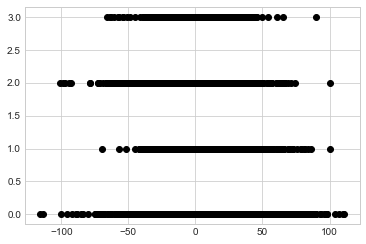

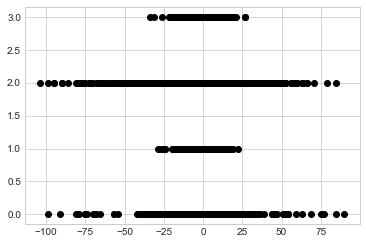

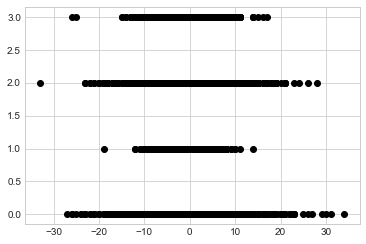

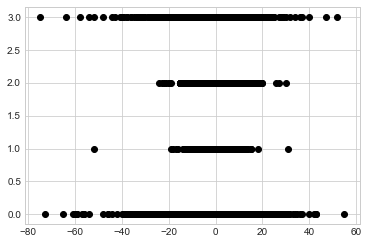

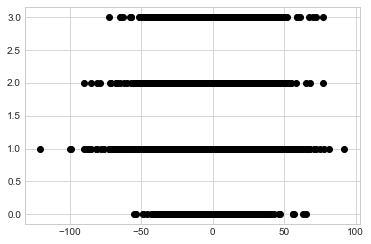

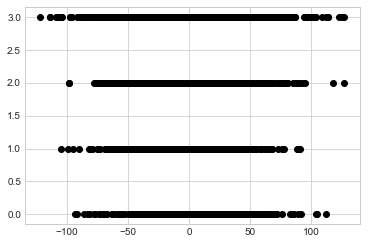

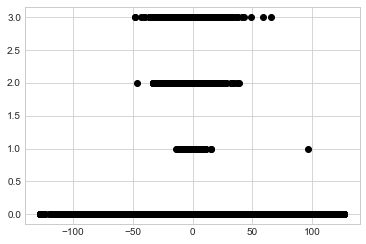

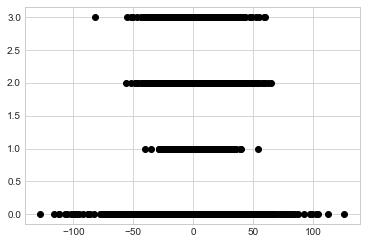

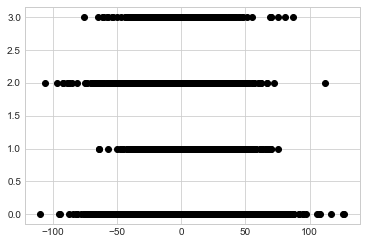

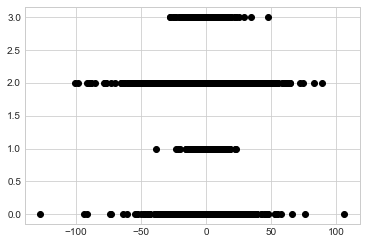

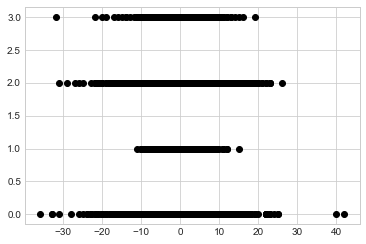

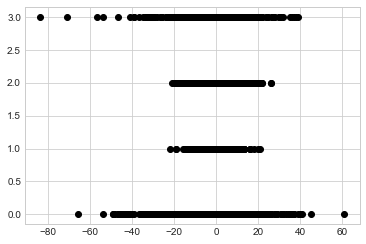

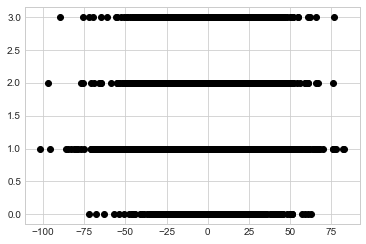

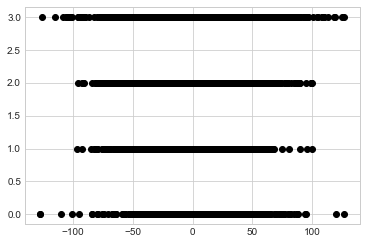

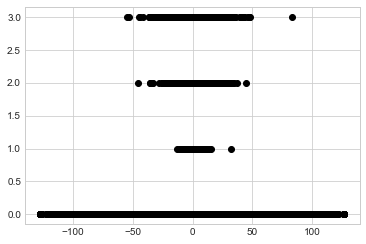

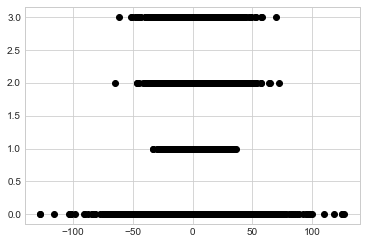

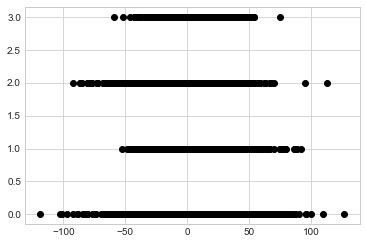

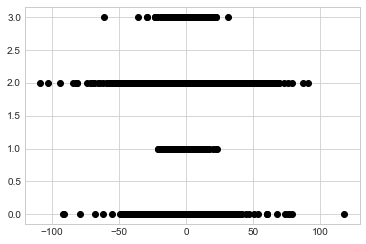

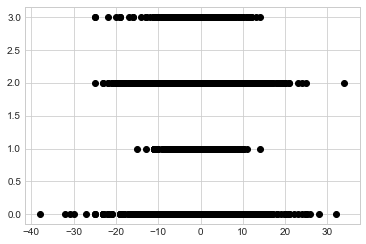

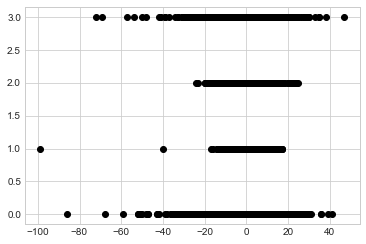

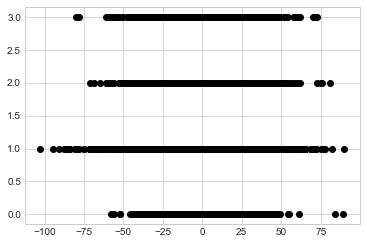

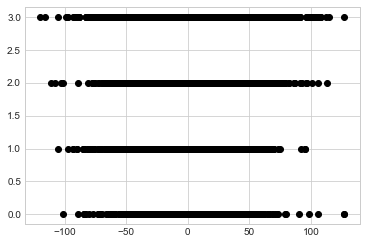

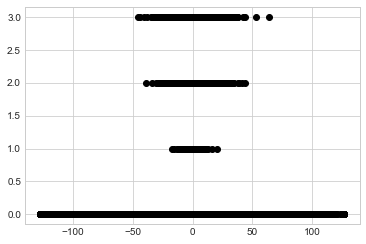

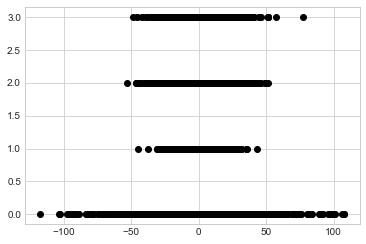

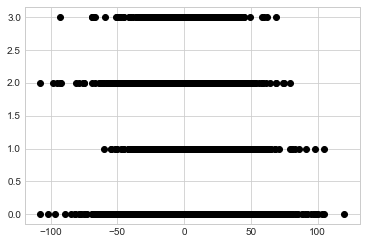

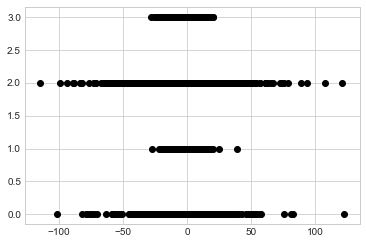

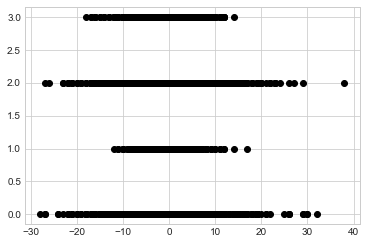

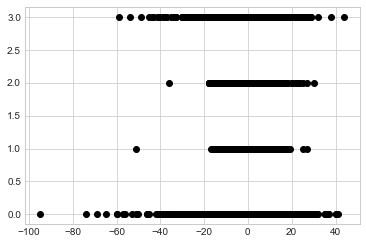

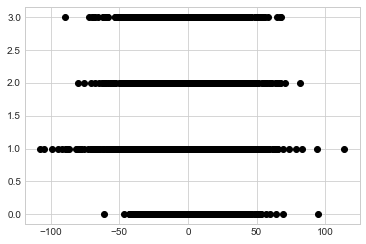

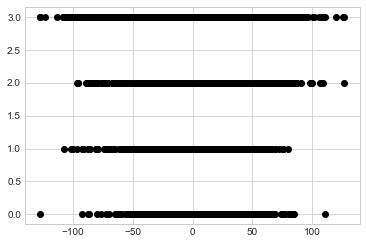

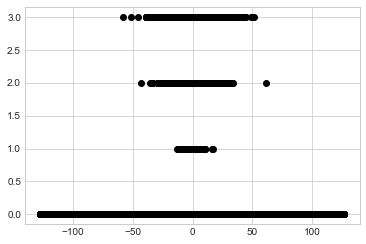

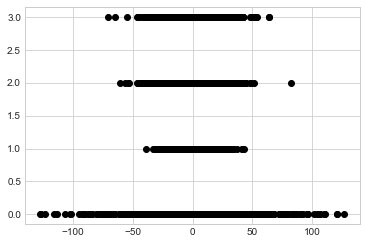

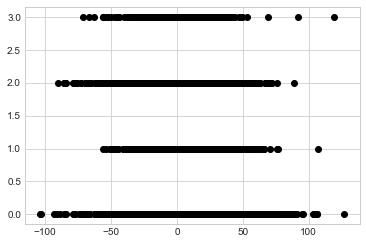

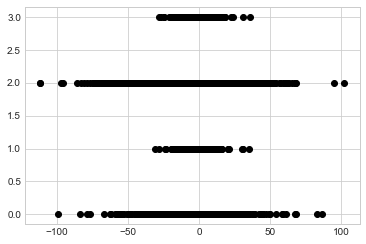

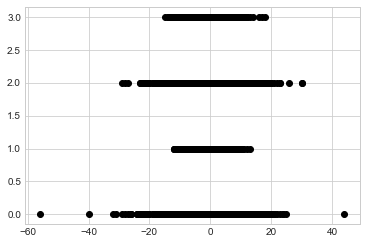

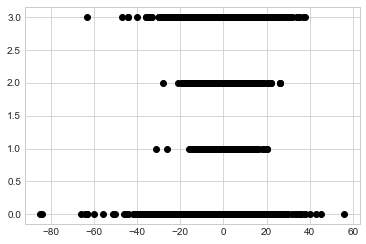

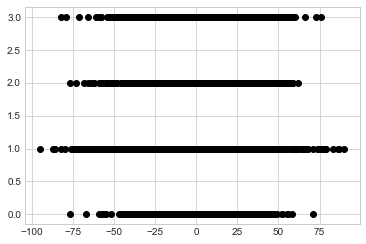

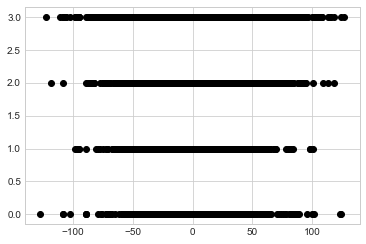

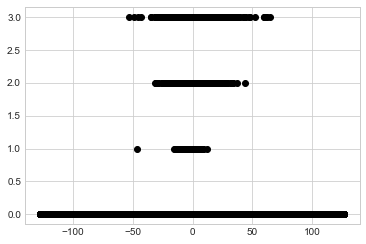

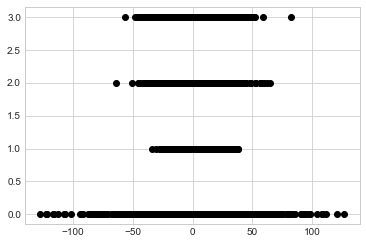

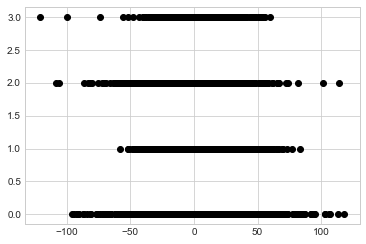

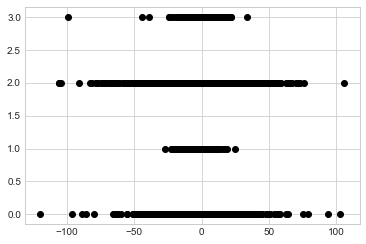

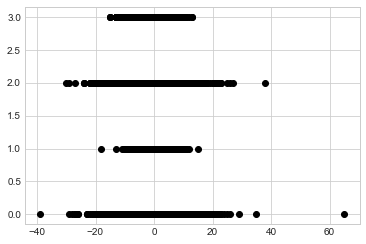

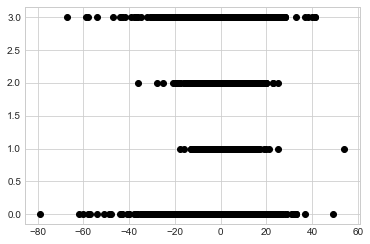

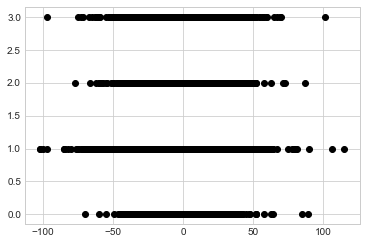

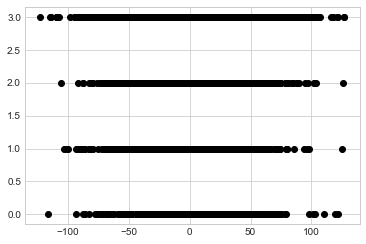

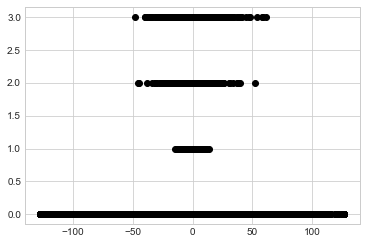

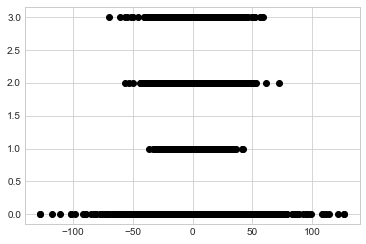

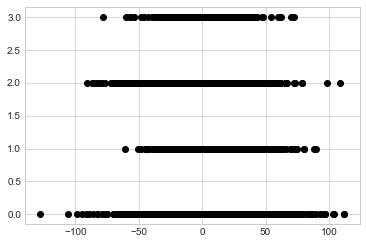

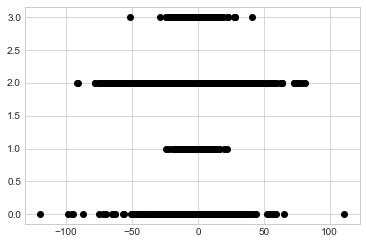

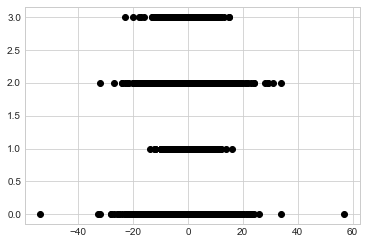

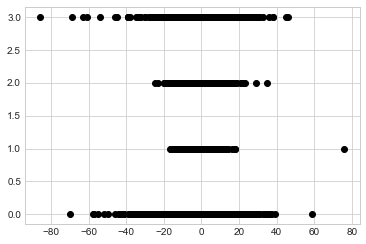

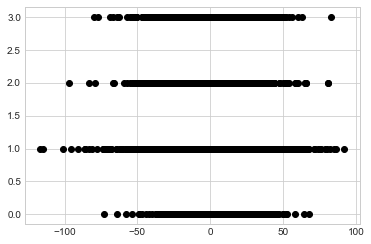

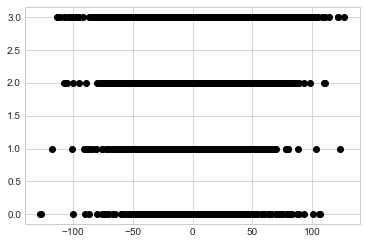

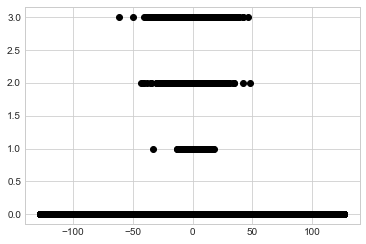

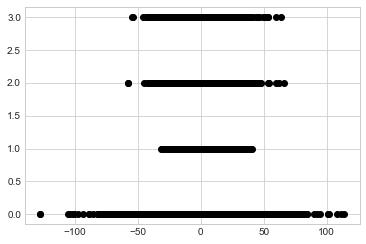

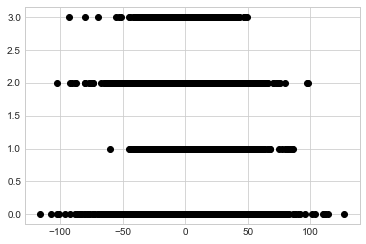

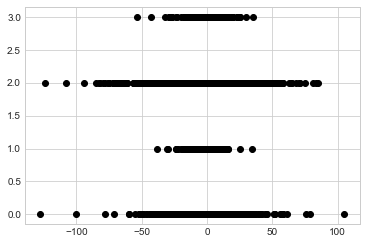

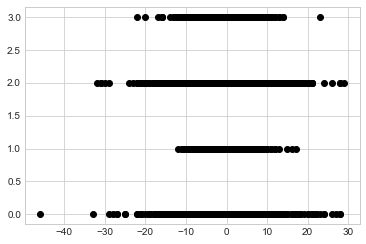

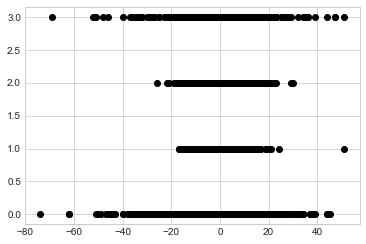

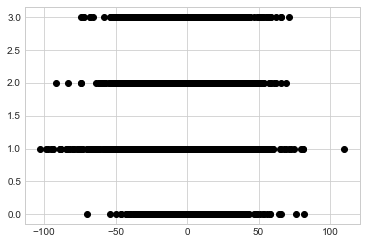

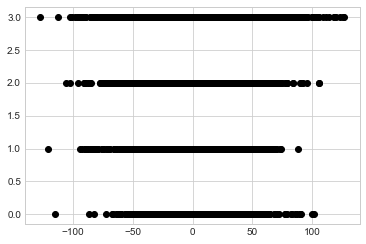

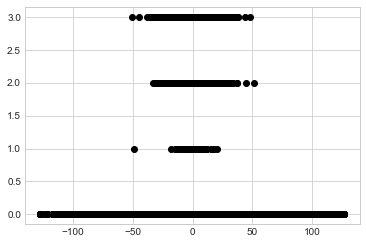

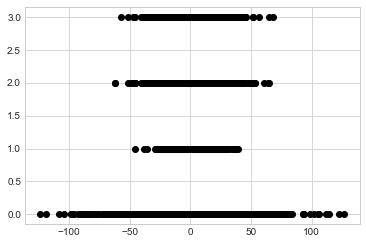

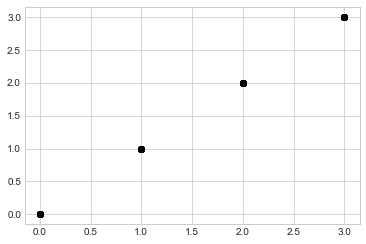

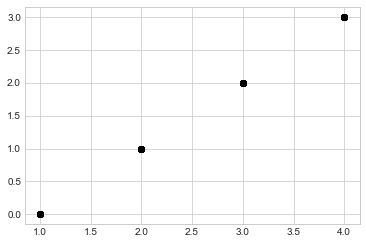

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

for i in df:
    x = df[i]
    y = df[64]

    plt.plot(x, y, 'o', color='black')
    plt.show()